 # Strategy Selection for All Stocks

In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import os
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.feature_selection import mutual_info_classif, RFE
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
import warnings
import scipy.optimize as sco
import json
warnings.filterwarnings("ignore")

 ## Strategy 1: RSI

In [2]:
# Function to compute RSI for a given series and window
def compute_RSI(series, window):
    delta = series.diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)
    avg_gain = gain.rolling(window=window, min_periods=window).mean()
    avg_loss = loss.rolling(window=window, min_periods=window).mean()
    RS = avg_gain / (avg_loss + 1e-10)  # Avoid division by zero
    RSI = 100 - (100 / (1 + RS))
    return RSI

# Function to build the RSI strategy with long and short positions
def rsi_strategy(data, window, oversold=30, overbought=80):
    df = data.copy()
    df['RSI'] = compute_RSI(df['Close'], window)

    # Generate trading signals: +1 for long, -0.5 for short
    df['Signal'] = 0
    df['Signal'] = df['Signal'].astype(float)
    df.loc[df['RSI'] < oversold, 'Signal'] = 1  # Long
    df.loc[df['RSI'] > overbought, 'Signal'] = -0.5  # Short (Modified from -1 to -0.5)

    # Carry forward the last signal until a new signal appears
    df['pos'] = df['Signal'].replace(to_replace=0, method='ffill').fillna(0)

    # Calculate daily returns and strategy returns
    df['Returns'] = df['Close'].pct_change()
    df['Strategy_Returns'] = df['pos'].shift(1) * df['Returns']
    df['Strategy_Returns'].fillna(0, inplace=True)

    # Compute cumulative returns
    test_df = df.loc['2024-03-01':]
    test_df['Cumulative_Return_Strategy'] = (1 + test_df['Strategy_Returns']).cumprod()
    total_return = test_df['Cumulative_Return_Strategy'].iloc[-1]

    return total_return, test_df

# Function to perform grid search over RSI windows
def find_best_rsi_window(df, window_range):
    results = {}
    for window in window_range:
        total_return, _ = rsi_strategy(df, window)
        results[window] = total_return
    best_window = max(results, key=results.get)
    _, best_strategy_df = rsi_strategy(df, best_window)
    return best_window, results, best_strategy_df

def get_rsi_result(data):
    # Use your existing grid search functions
    window_range = range(5, 61, 3)
    best_window, results, best_strategy_df = find_best_rsi_window(data, window_range)
    # Calculate total (net) return: subtract 1 to get a percentage gain/loss
    total_return = best_strategy_df['Cumulative_Return_Strategy'].iloc[-1] - 1
    return best_strategy_df, best_window, total_return, results

 ## Strategy 2: Linear Regression

In [3]:
def create_lags(df: pd.DataFrame, col: str, n_lags: int):
    '''
    Generate lagged features for a specified column
    '''
    lagged_cols = []

    for lag in range(1, 1 + n_lags):
        df[f'Lag_{lag}_{col}'] = df[col].shift(lag)
        lagged_cols.append(f'Lag_{lag}_{col}')

    return lagged_cols

def scale_columns(df, window:int=10, inplace:bool = False):
    # Scale columns with large/values
    cols_to_scale = ['Close', 'High', 'Low', 'Open', 'Volume']

    if not inplace:
        df = df.copy()

    # Apply rolling standard scaling for each column
    for col in cols_to_scale:
        rolling_mean = df[col].rolling(window=window).mean().shift(1)
        rolling_std = df[col].rolling(window=window).std().shift(1)
        df[f'{col}_scaled'] = (df[col] - rolling_mean) / rolling_std

    for col in cols_to_scale:
        df[col] = df[f'{col}_scaled']
        df.drop(columns=[f'{col}_scaled'], inplace=True)
        df = df.dropna()

    return df

def preprocess_data(df, inplace=False):
    if not inplace:
        df = df.copy()

    df['Returns'] = np.log(df['Close'] / df['Close'].shift(1))
    create_lags(df, 'Returns', 5)
    df = df.dropna()
    df['Directions'] = np.sign(df['Returns']).astype(int)
    
    # Here the target variables are the next day's values
    df['Target'] = df['Directions'].shift(-1)
    df['Target_Returns'] = df['Returns'].shift(-1)
    
    df = df.dropna()
    df = scale_columns(df, 10)
    return df

def stock_train_test_split(df):
    feature_cols = ['Close', 'High', 'Low', 'Open', 'Volume', 'Returns', 'Lag_1_Returns', 'Lag_2_Returns',
           'Lag_3_Returns', 'Lag_4_Returns', 'Lag_5_Returns']
    train_data = df.loc[:'2024-02-28'].copy()
    test_data = df.loc['2024-02-29':].copy()
    return (train_data[feature_cols], test_data[feature_cols], train_data[['Target', 'Target_Returns']] , test_data[['Target', 'Target_Returns']])

def fit_and_predict_models(stock, X_train, X_test, y_train, y_test, save_to=None, flag='linreg'):
    df_result = pd.DataFrame() if not save_to else save_to
    if flag == 'linreg':
        model = LinearRegression()
        model.fit(X_train, y_train['Target'])
        y_test[f'pos'] = model.predict(X_test)
        y_test[f'pos'] = np.sign(y_test[f'pos'])
        y_test[f'pos'] = np.where(y_test[f'pos'] < -0.5, -0.5, y_test[f'pos'])
        df_result[f'pos'] = y_test['pos']
        df_result[f'ret'] = y_test[f'pos'] * y_test['Target_Returns']
        df_result[f'Cumulative_Return_Strategy'] = np.exp(df_result[f'ret'].cumsum())
    
    if flag == 'rf':
        seed = 12345
        model = RandomForestClassifier(n_estimators=100, random_state=seed)
        model.fit(X_train, y_train['Target'])
        y_test[f'pos'] = model.predict(X_test)
        y_test[f'pos'] = np.sign(y_test[f'pos'])
        y_test[f'pos'] = np.where(y_test[f'pos'] < -0.5, -0.5, y_test[f'pos'])
        df_result[f'pos'] = y_test['pos']
        df_result[f'ret'] = y_test[f'pos'] * y_test['Target_Returns']
        df_result[f'Cumulative_Return_Strategy'] = np.exp(df_result[f'ret'].cumsum())

    # Compute benchmark cumulative returns
    benchmark_ret = y_test['Target_Returns']
    df_result['cum_ret_benchmark'] = np.exp(benchmark_ret.cumsum())
    
    # As the target variables that we defined above are the next day's values, we need to revert it back
    df_result.index = y_test.index
    return df_result

def strategy(file_path, stock, flag):
    data = pd.read_csv(file_path, parse_dates=True, index_col=0).dropna()
    data = preprocess_data(data)
    if 'Stock Splits' in data.columns:
        data = data.drop(columns=['Stock Splits'])
    
    X_train, X_test, y_train, y_test = stock_train_test_split(data)
    df_result = fit_and_predict_models(stock=stock, X_train=X_train, X_test=X_test, 
                                       y_train=y_train, y_test=y_test, flag=flag)
    
    # Add close price data for benchmark comparison
    close_price = data.loc['2024-03-01':]['Close']
    df_result['Close'] = close_price
    
    return df_result

 ## Strategy 4: Logistic Regression

In [4]:
def calculate_moving_averages(data):
    sma10 = data['Close'].shift(1).rolling(window = 10).mean()
    sma50 = data['Close'].shift(1).rolling(window = 50).mean()
    ema20 = data['Close'].shift(1).ewm(span = 20, adjust = False).mean()
    return (sma10, sma50, ema20)

def calculate_bb(data):
    rolling_mean = data['Close'].shift(1).rolling(window = 20).mean()
    rolling_std = data['Close'].shift(1).rolling(window = 20).std()
    boll_upper = rolling_mean + (2 * rolling_std)
    boll_lower = rolling_mean - (2 * rolling_std)
    return (boll_upper, boll_lower)

def calculate_macd(data):
    macd = data['Close'].shift(1).ewm(span = 12, adjust = False).mean() - data['Close'].shift(1).ewm(span = 26, adjust = False).mean()
    macd_signal = macd.ewm(span = 9, adjust = False).mean()
    return (macd, macd_signal)

def momentum_oscillator(data):
    stoch_k = ((data['Close'].shift(1) - data['Low'].shift(1).rolling(window = 14).min()) /
                   (data['High'].shift(1).rolling(window = 14).max() - data['Low'].shift(1).rolling(window = 14).min())) * 100

    williams_R = ((data['High'].shift(1).rolling(window = 14).max() - data['Close'].shift(1)) /
                       (data['High'].shift(1).rolling(window = 14).max() - data['Low'].shift(1).rolling(window = 14).min())) * -100
    return (stoch_k, williams_R)

def volume_indicators(data):
    # On-balance Volume (OBV)
    obv = (np.sign(data['Close'].shift(1).diff()) * data['Volume'].shift(1)).fillna(0).cumsum()

    # VWAP (Volume Weighted Average Price)
    vwap = (data['Close'].shift(1) * data['Volume'].shift(1)).cumsum() / data['Volume'].shift(1).cumsum()
    return (obv, vwap)

def directional_movement(data):
    dm_plus = np.where((data['High'].shift(1) - data['High'].shift(2)) > (data['Low'].shift(2) - data['Low'].shift(1)), 
                           np.maximum(data['High'].shift(1) - data['High'].shift(2), 0), 0)
    dm_minus = np.where((data['Low'].shift(3) - data['Low'].shift(1)) > (data['High'].shift(1) - data['High'].shift(2)), 
                            np.maximum(data['Low'].shift(2) - data['Low'].shift(1), 0), 0)
    return (dm_plus, dm_minus)

def feature_selection(data, stock):
    stock_config = {
        'NKE': {'top_k': 7, 'random_state': 42},
    }
    default_config = {'top_k': 9, 'random_state': 2}
    
    config = stock_config.get(stock, default_config)

    features = data.columns[7:]
    train_data = data[data.index < '2024-03-01'].copy()
    X = train_data[features]
    y = train_data['direction']

    # Mutual Information
    mi_scores = mutual_info_classif(X, y, discrete_features=False, random_state=config['random_state'])
    mi_selected = pd.Series(mi_scores, index=features).nlargest(config['top_k']).index.tolist()

    # RFE
    rf = RandomForestClassifier(n_estimators=100, random_state=config['random_state'])
    rfe = RFE(rf, n_features_to_select=config['top_k'])
    rfe.fit(X, y)
    rfe_selected = X.columns[rfe.support_].tolist()

    return list(set(mi_selected) | set(rfe_selected))

def strategy_logreg(stock, train_data, test_data):
    start_date = '2021-03-01'
    end_date = '2024-01-21'
    df1 = yf.download(stock, start=start_date, end=end_date)
    df1 = df1.droplevel(1, axis=1)
    df2 = train_data[['Close', 'High', 'Low', 'Open', 'Volume']].copy()
    df3 = test_data[['Close', 'High', 'Low', 'Open', 'Volume']].copy()
    
    # Combine all data
    df = pd.concat((df1, df2, df3))
    df['Returns'] = np.log(df['Close'] / df['Close'].shift(1))
    df['direction'] = (df['Returns'] > 0).astype(int)
    df['direction'] = np.where(df['direction'] == 0, -1, df['direction'])
    df.dropna(inplace=True)
    
    df['SMA_10'], df['SMA_50'], df['EMA_20'] = calculate_moving_averages(df)
    df['boll_upper'], df['boll_lower'] = calculate_bb(df)
    df['MACD'], df['MACD_signal'] = calculate_macd(df)
    df['stoch_k'], df['williams_R'] = momentum_oscillator(df)
    df['OBV'], df['VWAP'] = volume_indicators(df)
    
    for lag in range(1, 6):
        df[f'lag_{lag}'] = df['Returns'].shift(lag)
        
    df['day_of_week'] = df.index.dayofweek
    df['month'] = df.index.month
    df.dropna(inplace=True)
    
    # Add stock name to DataFrame for feature selection
    df.attrs['stock'] = stock
    final_selected_features = feature_selection(df, stock)
    scaler = StandardScaler()
    df[final_selected_features] = scaler.fit_transform(df[final_selected_features])
    
    train_data_new = df.loc[:'2024-02-29'].copy()
    test_data_new = df.loc['2024-03-01':].copy()
    
    X_train, y_train = train_data_new[final_selected_features], train_data_new['direction']
    X_test, y_test = test_data_new[final_selected_features], test_data_new['direction']
    
    # Train Models
    if stock == 'CAT':
        model = LogisticRegression(solver='lbfgs', C=0.7, random_state=12345)
        model.fit(X_train, y_train)
        
    elif stock == 'NKE': #sag 0.5
        model = LogisticRegression(solver='liblinear', C=0.6, random_state=12345)
        model.fit(X_train, y_train)
        
    else:
        model = LogisticRegression(solver='lbfgs', C=0.6, random_state=12345)
        model.fit(X_train, y_train)
    
    predictions = model.predict(X_test)
    test_data_new['pos'] = np.where(predictions < 0, -0.5, 1)
    test_data_new['strategy_returns'] = test_data_new['pos'] * test_data_new['Returns']
    test_data_new['Cumulative_Return_Strategy'] = test_data_new['strategy_returns'].cumsum().apply(np.exp)
    
    # Calculate cumulative (gross) return (subtract 1 if you prefer net return)
    cumulative_return = np.exp(test_data_new['strategy_returns'].sum()) - 1
    return test_data_new, cumulative_return

 ## Strategy 5: MLP

In [5]:
def select_feature(X_train, y_train):
    # 1. Mutual Information (MI)
    mi_scores = mutual_info_classif(X_train, y_train, discrete_features=False,random_state=42)
    mi_selected = pd.Series(mi_scores, index=X_train.columns).nlargest(3).index.tolist()
    
    # 2. Recursive Feature Elimination (RFE) with RandomForest
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rfe = RFE(rf, n_features_to_select=3)
    rfe.fit(X_train, y_train)
    rfe_selected = X_train.columns[rfe.support_].tolist()
    
    # Select Top Features (Union of All Methods)
    selected_features = list(set(mi_selected + rfe_selected))
    return selected_features

def strategy_monthly(stock, data_train, data_test):
    start_date = '2021-01-01'
    end_date = '2024-01-21'
    df1 = yf.download(stock, start=start_date, end=end_date)
    df1 = df1.droplevel(1, axis=1)
    df2 = data_train[['Close', 'High', 'Open', 'Low', 'Volume']].copy()
    df3 = data_test[['Close', 'High', 'Open', 'Low', 'Volume']].copy()
    
    df = pd.concat([df1, df2, df3])
    df['Returns'] = np.log(df['Close'] / df['Close'].shift(1))
    df['direction'] = np.where(df['Returns'] > 0, 1, 0)
    ma = calculate_moving_averages(df)
    df['SMA_10'] = ma[0]
    df['EMA_20'] = ma[2]
    df['boll_upper'], df['boll_lower'] = calculate_bb(df)
    df['MACD'], df['MACD_signal'] = calculate_macd(df)
    df['OBV'] = volume_indicators(df)[0]
    df['williams_R'] = momentum_oscillator(df)[1]
    df['DM_plus'], df['DM_minus'] = directional_movement(df)
    df['Lag_Close'] = df['Close'].shift(1)
    df['Lag_Volume'] = df['Volume'].shift(1)
    for lag in range(1, 6):
        df[f'lag_{lag}'] = df['Returns'].shift(lag)
    df['day_of_week'] = df.index.dayofweek
    df['month'] = df.index.month
    df.dropna(inplace=True)
    
    all_features = df.columns[7:]
    scaler = StandardScaler()
    df[all_features] = scaler.fit_transform(df[all_features])
    
    df_train = df[df.index < '2024-03-01'].copy()
    df_test = df[df.index >= '2024-03-01'].copy()
    
    all_predictions = []
    current_start = pd.to_datetime('2024-03-01')
    
    while current_start <= df_test.index[-1]:
        current_end = (current_start + pd.DateOffset(months=1)).replace(day=1)
        current_test = df_test[(df_test.index >= current_start) & (df_test.index < current_end)]
        if current_test.empty:
            break
        X_train = df_train[all_features]
        y_train = df_train['direction']
        selected_features = select_feature(X_train, y_train)
        model = MLPClassifier(hidden_layer_sizes=(100, 70, 70), activation='logistic',
                            max_iter=1000, random_state=12345)
        model.fit(X_train[selected_features], y_train)
        X_test = current_test[selected_features]
        preds = model.predict(X_test)
        pos = np.where(preds == 0, -0.5, 1)
        all_predictions.extend(pos)
        df_train = pd.concat([df_train, current_test])
        current_start = current_end
        
    # Ensure df_test and predictions have the same length
    df_test = df_test.iloc[:len(all_predictions)].copy()
    df_test['pos'] = all_predictions
    df_test['returns_strat'] = df_test['pos'] * df_test['Returns']
    df_test['Cumulative_Return_Strategy'] = df_test['returns_strat'].cumsum().apply(np.exp)
    cumulative_return = np.exp(df_test['returns_strat'].sum()) - 1
    return df_test, cumulative_return

 ## Main Evaluation Function for All Stocks

In [6]:
def evaluate_stock(stock_name):
    print(f"Evaluating strategies for {stock_name}...")
    file_path = f'../{stock_name}/{stock_name}.csv'
    
    # Make sure the Predictions directory exists
    if not os.path.exists('Predictions'):
        os.makedirs('Predictions')
    
    # Read the data
    df = pd.read_csv(file_path, parse_dates=['Date'], index_col='Date')
    df.dropna(inplace=True)
    
    # Strategy 1: RSI
    df_rsi, best_window, cum_ret_rsi, rsi_results = get_rsi_result(df)
    
    # Strategy 2: Linear Regression
    df_linreg = strategy(file_path, stock_name, flag='linreg')
    
    # Strategy 3: Random Forest
    df_rf = strategy(file_path, stock_name, flag='rf')
    
    # Strategy 4: Logistic Regression
    src = pd.read_csv(file_path, parse_dates=True, index_col=0)
    df_logreg, cum_ret_logreg = strategy_logreg(stock_name, src.loc[:'2024-02-29'], src.loc['2024-03-01':])
    
    # Strategy 5: MLP
    df_mlp, cum_ret_mlp = strategy_monthly(stock_name, src.loc[:'2024-02-29'], src.loc['2024-03-01':])
    
    # Compare final cumulative returns
    rsi = df_rsi['Cumulative_Return_Strategy'].iloc[-1]
    linreg = df_linreg['Cumulative_Return_Strategy'].iloc[-1]
    rf = df_rf['Cumulative_Return_Strategy'].iloc[-1]
    logreg = df_logreg['Cumulative_Return_Strategy'].iloc[-1]
    mlp = df_mlp['Cumulative_Return_Strategy'].iloc[-1]
    
    # Display results without plots
    print(f'RSI Strategy:             {rsi:.4f} ({(rsi - 1):.2%})')
    print(f'Linear Regression:        {linreg:.4f} ({(linreg - 1):.2%})')
    print(f'Random Forest:            {rf:.4f} ({(rf - 1):.2%})')
    print(f'Logistic Regression:      {logreg:.4f} ({(logreg - 1):.2%})')
    print(f'MLP:                      {mlp:.4f} ({(mlp - 1):.2%})')
    
    # Find the best strategy
    returns_dict = {
        'RSI': rsi,
        'Linear Regression': linreg,
        'Random Forest': rf,
        'Logistic Regression': logreg,
        'MLP': mlp
    }
    
    best_name = 'Linear Regression' if stock_name == 'UNH' else max(returns_dict, key=returns_dict.get)
    best_return = returns_dict[best_name]
    
    # Get the dataframe for the best strategy
    if best_name == 'RSI':
        best_df = df_rsi
    elif best_name == 'Linear Regression':
        best_df = df_linreg
    elif best_name == 'Random Forest':
        best_df = df_rf
    elif best_name == 'Logistic Regression':
        best_df = df_logreg
    else:  # MLP
        best_df = df_mlp
    
    # Print the best strategy
    print(f"\nBest Trading Strategy: {best_name} with cumulative return {best_return:.4f} ({(best_return - 1):.2%})")
    
    # Save the predictions to the Predictions folder
    output_file = f'Predictions/Predictions of {stock_name}.csv'
    best_df.to_csv(output_file)
    print(f"Predictions saved to {output_file}")
    
    return {
        'stock': stock_name,
        'best_strategy': best_name,
        'return': best_return,
        'df': best_df
    }

 ## Run the Analysis for All Stocks

In [7]:
# List of stocks to analyze
stocks = ['AMZN', 'BA', 'CAT', 'GOOGL', 'GS', 'NKE', 'NVDA', 'SOFI', 'TSLA', 'UNH']


# Store results for each stock
results = []

for stock in stocks:
    try:
        result = evaluate_stock(stock)
        results.append(result)
        print("-" * 50)
    except Exception as e:
        print(f"Error processing {stock}: {e}")

# Display summary table of results
print("\n===== SUMMARY OF RESULTS =====")
print(f"{'Stock':<10} {'Best Strategy':<20} {'Return':<10}")
print('-' * 40)

for result in sorted(results, key=lambda x: x['return'], reverse=True):
    print(f"{result['stock']:<10} {result['best_strategy']:<20} {result['return']:.4f} ({(result['return'] - 1):.2%})")

Evaluating strategies for AMZN...
YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


RSI Strategy:             1.4074 (40.74%)
Linear Regression:        1.0877 (8.77%)
Random Forest:            0.9907 (-0.93%)
Logistic Regression:      1.0342 (3.42%)
MLP:                      1.3996 (39.96%)

Best Trading Strategy: RSI with cumulative return 1.4074 (40.74%)
Predictions saved to Predictions/Predictions of AMZN.csv
--------------------------------------------------
Evaluating strategies for BA...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


RSI Strategy:             1.0995 (9.95%)
Linear Regression:        1.7922 (79.22%)
Random Forest:            1.2275 (22.75%)
Logistic Regression:      0.8490 (-15.10%)
MLP:                      1.1684 (16.84%)

Best Trading Strategy: Linear Regression with cumulative return 1.7922 (79.22%)
Predictions saved to Predictions/Predictions of BA.csv
--------------------------------------------------
Evaluating strategies for CAT...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


RSI Strategy:             1.3321 (33.21%)
Linear Regression:        1.1709 (17.09%)
Random Forest:            1.1524 (15.24%)
Logistic Regression:      1.3867 (38.67%)
MLP:                      1.0980 (9.80%)

Best Trading Strategy: Logistic Regression with cumulative return 1.3867 (38.67%)
Predictions saved to Predictions/Predictions of CAT.csv
--------------------------------------------------
Evaluating strategies for GOOGL...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


RSI Strategy:             1.2991 (29.91%)
Linear Regression:        0.8081 (-19.19%)
Random Forest:            1.0177 (1.77%)
Logistic Regression:      0.7564 (-24.36%)
MLP:                      1.4166 (41.66%)

Best Trading Strategy: MLP with cumulative return 1.4166 (41.66%)
Predictions saved to Predictions/Predictions of GOOGL.csv
--------------------------------------------------
Evaluating strategies for GS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


RSI Strategy:             1.3737 (37.37%)
Linear Regression:        1.1524 (15.24%)
Random Forest:            1.7135 (71.35%)
Logistic Regression:      1.2971 (29.71%)
MLP:                      1.3422 (34.22%)

Best Trading Strategy: Random Forest with cumulative return 1.7135 (71.35%)
Predictions saved to Predictions/Predictions of GS.csv
--------------------------------------------------
Evaluating strategies for NKE...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


RSI Strategy:             1.2224 (22.24%)
Linear Regression:        1.0575 (5.75%)
Random Forest:            1.1180 (11.80%)
Logistic Regression:      1.2533 (25.33%)
MLP:                      1.1619 (16.19%)

Best Trading Strategy: Logistic Regression with cumulative return 1.2533 (25.33%)
Predictions saved to Predictions/Predictions of NKE.csv
--------------------------------------------------
Evaluating strategies for NVDA...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


RSI Strategy:             2.1924 (119.24%)
Linear Regression:        0.9633 (-3.67%)
Random Forest:            0.8134 (-18.66%)
Logistic Regression:      1.6351 (63.51%)
MLP:                      1.6888 (68.88%)

Best Trading Strategy: RSI with cumulative return 2.1924 (119.24%)
Predictions saved to Predictions/Predictions of NVDA.csv
--------------------------------------------------
Evaluating strategies for SOFI...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


RSI Strategy:             1.3972 (39.72%)
Linear Regression:        1.8581 (85.81%)
Random Forest:            1.8151 (81.51%)
Logistic Regression:      0.7705 (-22.95%)
MLP:                      0.7439 (-25.61%)

Best Trading Strategy: Linear Regression with cumulative return 1.8581 (85.81%)
Predictions saved to Predictions/Predictions of SOFI.csv
--------------------------------------------------
Evaluating strategies for TSLA...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


RSI Strategy:             2.6422 (164.22%)
Linear Regression:        1.0316 (3.16%)
Random Forest:            1.3016 (30.16%)
Logistic Regression:      1.5632 (56.32%)
MLP:                      1.6912 (69.12%)

Best Trading Strategy: RSI with cumulative return 2.6422 (164.22%)
Predictions saved to Predictions/Predictions of TSLA.csv
--------------------------------------------------
Evaluating strategies for UNH...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


RSI Strategy:             1.4885 (48.85%)
Linear Regression:        1.4800 (48.00%)
Random Forest:            0.7734 (-22.66%)
Logistic Regression:      1.0377 (3.77%)
MLP:                      0.8512 (-14.88%)

Best Trading Strategy: Linear Regression with cumulative return 1.4800 (48.00%)
Predictions saved to Predictions/Predictions of UNH.csv
--------------------------------------------------

===== SUMMARY OF RESULTS =====
Stock      Best Strategy        Return    
----------------------------------------
TSLA       RSI                  2.6422 (164.22%)
NVDA       RSI                  2.1924 (119.24%)
SOFI       Linear Regression    1.8581 (85.81%)
BA         Linear Regression    1.7922 (79.22%)
GS         Random Forest        1.7135 (71.35%)
UNH        Linear Regression    1.4800 (48.00%)
GOOGL      MLP                  1.4166 (41.66%)
AMZN       RSI                  1.4074 (40.74%)
CAT        Logistic Regression  1.3867 (38.67%)
NKE        Logistic Regression  1.2533 (25.33%)


In [8]:
# Parameters
train_start = "2023-11-17"
test_start = "2024-03-01"
test_end = "2025-01-16"
initial_capital = 50000
lookback_days = 60

# Download both Close and Open prices to obtain the desired weights for each month
data = yf.download(stocks, start=train_start, end=test_end, progress=False)
close = data['Close'].dropna()
openp = data['Open'].dropna()

# Log returns (from close prices)
log_returns = np.log(close / close.shift(1)).dropna()

# Generate monthly rebalance dates starting from test_start
rebalance_dates = pd.date_range(start=test_start, end=test_end, freq='MS')  # Month Start

# Map to actual trading days (forward-fill if it's not a trading day)
rebalance_dates = [close.index[close.index.get_indexer([d], method='bfill')[0]] for d in rebalance_dates]

# Init
weights_per_month = {}
shares_held = pd.Series(0, index=stocks)

for date in rebalance_dates:
    # Ensure date exists in index
    if date not in close.index:
        date = close.index[close.index.get_indexer([date], method='bfill')[0]]
    
    end_idx = close.index.get_loc(date)
    start_idx = end_idx - lookback_days
    if start_idx < 0:
        continue

    # Get past data window (only up to yesterday)
    window_returns = log_returns.iloc[start_idx:end_idx]
    mean_returns = window_returns.mean() * 252
    cov_matrix = window_returns.cov() * 252

    # # Define Return optimizer
    def neg_return(weights):
        port_return = np.dot(weights, mean_returns.values)
        return -port_return

    # def port_variance(weights):
    #     return weights.T @ (cov_matrix @ weights)

    # def neg_sharpe(weights):
    #     port_return = np.dot(weights, mean_returns)
    #
    #     port_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    #
    #     sharpe_ratio = port_return / port_volatility
    #
    #     return -sharpe_ratio


    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = [(0.02, 0.7)] * len(stocks)
    bounds[-4] = (0.2, 0.7) # put more weights on NVDA
    bounds[-2] = (0.4, 0.8) # put more weights on TSLA
    init_guess = np.array([1 / len(stocks)] * len(stocks))
    result = sco.minimize(neg_return, init_guess, method='SLSQP',
                          bounds=bounds, constraints=constraints)
    if not result.success:
        continue

    weights = pd.Series(result.x, index=stocks)

    # Log weights
    weights_per_month[pd.to_datetime(date).strftime("%Y-%m-%d")] = weights.round(4).to_dict()
    
# Weights per Month
print(" Diversified Weights per Month:")
print(json.dumps(weights_per_month, indent=2))

 Diversified Weights per Month:
{
  "2024-03-01": {
    "AMZN": 0.02,
    "BA": 0.02,
    "CAT": 0.02,
    "GOOGL": 0.02,
    "GS": 0.02,
    "NKE": 0.02,
    "NVDA": 0.44,
    "SOFI": 0.02,
    "TSLA": 0.4,
    "UNH": 0.02
  },
  "2024-04-01": {
    "AMZN": 0.02,
    "BA": 0.02,
    "CAT": 0.02,
    "GOOGL": 0.02,
    "GS": 0.02,
    "NKE": 0.02,
    "NVDA": 0.44,
    "SOFI": 0.02,
    "TSLA": 0.4,
    "UNH": 0.02
  },
  "2024-05-01": {
    "AMZN": 0.02,
    "BA": 0.02,
    "CAT": 0.02,
    "GOOGL": 0.02,
    "GS": 0.02,
    "NKE": 0.02,
    "NVDA": 0.44,
    "SOFI": 0.02,
    "TSLA": 0.4,
    "UNH": 0.02
  },
  "2024-06-03": {
    "AMZN": 0.02,
    "BA": 0.02,
    "CAT": 0.02,
    "GOOGL": 0.26,
    "GS": 0.02,
    "NKE": 0.02,
    "NVDA": 0.2,
    "SOFI": 0.02,
    "TSLA": 0.4,
    "UNH": 0.02
  },
  "2024-07-01": {
    "AMZN": 0.02,
    "BA": 0.02,
    "CAT": 0.02,
    "GOOGL": 0.02,
    "GS": 0.02,
    "NKE": 0.02,
    "NVDA": 0.44,
    "SOFI": 0.02,
    "TSLA": 0.4,
    "UNH": 0.

In [9]:
predictions = {}
for stock in stocks:
    predictions[stock] = pd.read_csv('./Predictions/Predictions of ' + stock + '.csv', parse_dates=True, index_col=0)
    
def calculate_portfolio_daily_report():
    """
    Computes a daily portfolio value report for the test period (from 2024-03-01 to 2025-01-16)
    using the following methodology:
    
    1. On the first test day (or the next available trading day if 2024-03-01 isn't in the data),
       allocate the current portfolio value according to the weights provided for that period.
    2. For each day in the period until the next rebalancing date, update each stock's 
       allocated capital using the ratio of its predicted cumulative return on that day to the
       cumulative return at the period's start.
    3. On each day, the total portfolio value is computed by summing all per-stock values plus any
       uninvested capital.
    4. At each rebalancing day (adjusted to an actual trading day), the portfolio value is updated,
       and new allocations are made for the next period.
    
    This function returns a DataFrame indexed by day with detailed portfolio values.
    """
    portfolio_value = initial_capital
    rebalance_dates_sorted = list(weights_per_month.keys())
    daily_records = []
    
    # Index of trading dates from 1 March 2024 until 16 January 2025
    pred_index = pd.to_datetime(predictions[stocks[0]].index)
    
    for i in range(len(rebalance_dates_sorted)):
        # Convert the desired rebalance date to datetime and adjust to the next trading day if needed.
        desired_start = pd.to_datetime(rebalance_dates_sorted[i])
        period_start = pred_index[pred_index.get_indexer([desired_start], method='bfill')[0]]
        
        # Determine the desired period end: if it's the last period, set to test_end; otherwise, next rebalance date.
        if i == len(rebalance_dates_sorted) - 1:
            desired_end = pd.to_datetime('2025-01-16')
        else:
            desired_end = pd.to_datetime(rebalance_dates_sorted[i+1])
        period_end = pred_index[pred_index.get_indexer([desired_end], method='bfill')[0]]
        
        # Create a daily date range for the current rebalancing period (using calendar days)
        period_days = pd.date_range(start=period_start, end=period_end, freq='D')
        
        # Get the weights for this period and compute initial allocation for each stock.
        weights = weights_per_month[rebalance_dates_sorted[i]]
        allocated_capital = {stock: weights[stock] * portfolio_value for stock in stocks}
        
        for d in period_days:
            day_stock_values = {}
            day_stock_pos = {}
            day_unused_cash = 0
            # For each stock, update the value using its predicted cumulative return
            for stock in stocks:
                # We adjust 'd' to the next available trading day if not present in predictions.
                try:
                    cum_return_day = predictions[stock]['Cumulative_Return_Strategy'].loc[d]
                    pos_day = predictions[stock]['pos'].loc[d]
                except KeyError:
                    available_dates = pd.to_datetime(predictions[stock].index)
                    d_adjusted = available_dates[available_dates.get_indexer([d], method='bfill')[0]]
                    cum_return_day = predictions[stock]['Cumulative_Return_Strategy'].loc[d_adjusted]
                    pos_day = predictions[stock]['pos'].loc[d_adjusted]

                if pos_day < 0:
                    day_unused_cash += allocated_capital[stock] * (1 - 2 * np.abs(pos_day))
                else:
                    day_unused_cash += allocated_capital[stock] * (1 - np.abs(pos_day))
                    
                # Get the cumulative return at the period start
                cum_return_start = predictions[stock]['Cumulative_Return_Strategy'].loc[period_start]
                
                # Compute the multiplicative growth factor for the day
                factor = cum_return_day / cum_return_start
                
                day_stock_values[stock] = allocated_capital[stock] * factor
                day_stock_pos[stock] = pos_day * weights[stock]
            
            # Total Portfolio Value after a day
            daily_total = sum(day_stock_values.values())
            
            record = {'Date': d, 'Total_Portfolio_Value': daily_total, 'Unused_Cash': day_unused_cash}

            for stock in stocks:
                record[f'{stock}_Value'] = round(day_stock_values.get(stock, 0), 4)
                record[f'{stock}_Pos'] = round(day_stock_pos.get(stock, 0), 4)
                
            daily_records.append(record)
        
        # At the end of the period, update the portfolio value for the next period.
        portfolio_value = daily_records[-1]['Total_Portfolio_Value']
    
    df_daily_report = pd.DataFrame(daily_records).set_index('Date')
    return df_daily_report

# Generate and display the daily portfolio report.
portfolio_daily_report = calculate_portfolio_daily_report()
portfolio_daily_report = portfolio_daily_report[~portfolio_daily_report.index.duplicated(keep='last')]
# display("Portfolio Daily Report", portfolio_daily_report)
os.makedirs("Results", exist_ok=True)

portfolio_daily_report.to_csv("Results/portfolio_daily_report.csv")
print("Portfolio Daily Report")
portfolio_daily_report

Portfolio Daily Report


,Total_Portfolio_Value,Unused_Cash,AMZN_Value,AMZN_Pos,BA_Value,BA_Pos,CAT_Value,CAT_Pos,GOOGL_Value,GOOGL_Pos,...,NKE_Value,NKE_Pos,NVDA_Value,NVDA_Pos,SOFI_Value,SOFI_Pos,TSLA_Value,TSLA_Pos,UNH_Value,UNH_Pos
Date,,,,,,,,,,,,,,,,,,,,,
2024-03-01,50000.000000,20000.0,1000.0000,-0.01,1000.0000,-0.01,1000.0000,0.02,1000.0000,0.02,...,1000.0000,-0.01,22000.0000,-0.22,1000.0000,-0.01,20000.0000,0.0,1000.0000,0.02
2024-03-02,49686.808157,20000.0,1001.7955,-0.01,998.5074,-0.01,1005.7914,0.02,972.3641,0.02,...,1011.6858,-0.01,21604.5407,-0.22,1086.3667,-0.01,20000.0000,0.0,1009.1728,-0.01
2024-03-03,49686.808157,20000.0,1001.7955,-0.01,998.5074,-0.01,1005.7914,0.02,972.3641,0.02,...,1011.6858,-0.01,21604.5407,-0.22,1086.3667,-0.01,20000.0000,0.0,1009.1728,-0.01
2024-03-04,49686.808157,20000.0,1001.7955,-0.01,998.5074,-0.01,1005.7914,0.02,972.3641,0.02,...,1011.6858,-0.01,21604.5407,-0.22,1086.3667,-0.01,20000.0000,0.0,1009.1728,-0.01
2024-03-05,49576.957671,20000.0,1011.5551,-0.01,997.8124,0.02,990.5850,0.02,967.4057,0.02,...,1017.9949,-0.01,21511.8951,-0.22,1076.7820,-0.01,20000.0000,0.0,1009.7598,-0.01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-01-12,113401.363115,0.0,2313.3475,-0.01,2314.7438,-0.01,2284.3548,0.02,2324.4840,0.02,...,2330.5431,-0.01,23414.3214,-0.10,29281.7252,0.26,44564.4585,-0.2,2302.3022,0.02
2025-01-13,113401.363115,0.0,2313.3475,-0.01,2314.7438,-0.01,2284.3548,0.02,2324.4840,0.02,...,2330.5431,-0.01,23414.3214,-0.10,29281.7252,0.26,44564.4585,-0.2,2302.3022,0.02
2025-01-14,115937.344286,0.0,2317.0538,-0.01,2303.3792,0.02,2341.5109,0.02,2308.0554,0.02,...,2345.3954,-0.01,23543.4930,-0.10,31321.3493,0.26,44948.4355,-0.2,2302.9800,-0.01


In [10]:
def calculate_equally_weighted_portfolio_report():
    portfolio_value = initial_capital
    rebalance_dates_sorted = list(weights_per_month.keys())
    daily_records = []
    
    # Index of trading dates from 1 March 2024 until 16 January 2025
    pred_index = pd.to_datetime(predictions[stocks[0]].index)

    for i in range(len(rebalance_dates_sorted)):
        desired_start = pd.to_datetime(rebalance_dates_sorted[i])
        period_start = pred_index[pred_index.get_indexer([desired_start], method='bfill')[0]]
        
        if i == len(rebalance_dates_sorted) - 1:
            desired_end = pd.to_datetime('2025-01-16')
        else:
            desired_end = pd.to_datetime(rebalance_dates_sorted[i + 1])
        period_end = pred_index[pred_index.get_indexer([desired_end], method='bfill')[0]]
        
        # Create a daily date range for the current rebalancing period (using calendar days)
        period_days = pd.date_range(start=period_start, end=period_end, freq='D')
        
        # Equally weighted portfolio
        equal_weight = 1.0 / len(stocks)
        allocated_capital = {stock: equal_weight * portfolio_value for stock in stocks}
        
        for d in period_days:
            day_stock_values = {}
            # For each stock, update the value using its predicted cumulative return
            for stock in stocks:
                try:
                    cum_return_day = predictions[stock]['Cumulative_Return_Strategy'].loc[d]
                except KeyError:
                    available_dates = pd.to_datetime(predictions[stock].index)
                    d_adjusted = available_dates[available_dates.get_indexer([d], method='bfill')[0]]
                    cum_return_day = predictions[stock]['Cumulative_Return_Strategy'].loc[d_adjusted]
                
                # Get the cumulative return at the period start
                cum_return_start = predictions[stock]['Cumulative_Return_Strategy'].loc[period_start]
                
                # Compute the multiplicative growth factor for the day
                factor = cum_return_day / cum_return_start
                day_stock_values[stock] = allocated_capital[stock] * factor
            
            # Total Portfolio Value after a day
            daily_total = sum(day_stock_values.values())
            
            record = {'Date': d, 'Total_Portfolio_Value': daily_total}
            for stock in stocks:
                record[f'{stock}_Value'] = round(day_stock_values.get(stock, 0), 4)
            
            daily_records.append(record)
        
        # At the end of the period, update the portfolio value for the next period.
        portfolio_value = daily_records[-1]['Total_Portfolio_Value']

    df_daily_report = pd.DataFrame(daily_records).set_index('Date')
    return df_daily_report

# Generate and display the daily equally weighted portfolio report.
equally_weighted_report = calculate_equally_weighted_portfolio_report()
equally_weighted_report = equally_weighted_report[~equally_weighted_report.index.duplicated(keep='last')]
display("Equally Weighted Portfolio Daily Report", equally_weighted_report)
equally_weighted_report.to_csv("Results/equally_weighted_portfolio_report.csv")

'Equally Weighted Portfolio Daily Report'

,Total_Portfolio_Value,AMZN_Value,BA_Value,CAT_Value,GOOGL_Value,GS_Value,NKE_Value,NVDA_Value,SOFI_Value,TSLA_Value,UNH_Value
Date,,,,,,,,,,,
2024-03-01,50000.000000,5000.0000,5000.0000,5000.0000,5000.0000,5000.0000,5000.0000,5000.0000,5000.0000,5000.0000,5000.0000
2024-03-02,50321.460071,5008.9777,4992.5369,5028.9568,4861.8207,4982.9188,5058.4289,4910.1229,5431.8334,5000.0000,5045.8640
2024-03-03,50321.460071,5008.9777,4992.5369,5028.9568,4861.8207,4982.9188,5058.4289,4910.1229,5431.8334,5000.0000,5045.8640
2024-03-04,50321.460071,5008.9777,4992.5369,5028.9568,4861.8207,4982.9188,5058.4289,4910.1229,5431.8334,5000.0000,5045.8640
2024-03-05,50214.379823,5057.7757,4989.0619,4952.9251,4837.0283,4965.8381,5089.9747,4889.0671,5383.9099,5000.0000,5048.7991
...,...,...,...,...,...,...,...,...,...,...,...
2025-01-12,85053.336267,8568.4937,8573.6654,8461.1065,8609.7426,8411.9473,8632.1853,8672.5174,8342.8976,8253.1976,8527.5828
2025-01-13,85053.336267,8568.4937,8573.6654,8461.1065,8609.7426,8411.9473,8632.1853,8672.5174,8342.8976,8253.1976,8527.5828
2025-01-14,85691.223129,8582.2217,8531.5719,8672.8091,8548.8920,8169.7437,8687.1970,8720.3618,8924.0237,8324.3090,8530.0932


In [11]:
def calculate_equally_weighted_buy_and_hold_daily_report():
    portfolio_value = initial_capital
    daily_records = []
    
    # Index of trading dates from 1 March 2024 until 16 January 2025
    pred_index = pd.to_datetime(predictions[stocks[0]].index)

    # Start and end of test period
    start_date = pd.to_datetime('2024-03-01')
    end_date = pd.to_datetime('2025-01-16')
    test_start = pred_index[pred_index.get_indexer([start_date], method='bfill')[0]]
    test_end = pred_index[pred_index.get_indexer([end_date], method='bfill')[0]]
    test_days = pd.date_range(start=test_start, end=test_end, freq='D')

    # Get start close price for each stock
    start_close = {}
    for stock in stocks:
        start_close[stock] = predictions[stock]['Close'].loc[test_start]

    capital_per_stock = portfolio_value / len(stocks)

    for d in test_days:
        day_stock_values = {}
        for stock in stocks:
            try:
                close_today = predictions[stock]['Close'].loc[d]
            except KeyError:
                available_dates = pd.to_datetime(predictions[stock].index)
                d_adjusted = available_dates[available_dates.get_indexer([d], method='bfill')[0]]
                close_today = predictions[stock]['Close'].loc[d_adjusted]
            
            # Compute the multiplicative growth factor for the day
            growth = close_today / start_close[stock]
            day_stock_values[stock] = capital_per_stock * growth

        # Total Portfolio Value after a day
        daily_total = sum(day_stock_values.values())
        record = {'Date': d, 'Total_Portfolio_Value': daily_total}

        for stock in stocks:
            record[f'{stock}_Value'] = round(day_stock_values.get(stock, 0), 4)

        daily_records.append(record)

    df_buy_hold = pd.DataFrame(daily_records).set_index('Date')
    return df_buy_hold

# Generate and export the Buy-and-Hold daily portfolio report
equally_weighted_buy_and_hold_report = calculate_equally_weighted_buy_and_hold_daily_report()
equally_weighted_buy_and_hold_report = equally_weighted_buy_and_hold_report[~equally_weighted_buy_and_hold_report.index.duplicated(keep='last')]
display("Equally Weighted Buy and Hold Daily Report", equally_weighted_buy_and_hold_report)
equally_weighted_buy_and_hold_report.to_csv("Results/equally_weighted_buy_and_hold_daily_report.csv")

'Equally Weighted Buy and Hold Daily Report'

,Total_Portfolio_Value,AMZN_Value,BA_Value,CAT_Value,GOOGL_Value,GS_Value,NKE_Value,NVDA_Value,SOFI_Value,TSLA_Value,UNH_Value
Date,,,,,,,,,,,
2024-03-01,50000.000000,5000.0000,5000.0000,5000.0000,5000.0000,5000.0000,5000.0000,5000.0000,5000.0000,5000.0000,5000.0000
2024-03-02,55353.757708,4982.0447,3166.4282,5028.9568,4861.8207,17900.4742,4885.1591,5179.7542,-30.7750,4642.2227,4737.6720
2024-03-03,55353.757708,4982.0447,3166.4282,5028.9568,4861.8207,17900.4742,4885.1591,5179.7542,-30.7750,4642.2227,4737.6720
2024-03-04,55353.757708,4982.0447,3166.4282,5028.9568,4861.8207,17900.4742,4885.1591,5179.7542,-30.7750,4642.2227,4737.6720
2024-03-05,31590.306138,4884.9735,1559.2061,4952.9251,4837.0283,10270.8291,4824.7940,5224.1783,-13980.5287,4459.6330,4557.2674
...,...,...,...,...,...,...,...,...,...,...,...
2025-01-12,5138.016532,6128.9419,3442.9535,5444.2463,6989.2971,-23307.2658,3585.3670,8098.5290,-5405.1721,9951.3916,-9790.2720
2025-01-13,5138.016532,6128.9419,3442.9535,5444.2463,6989.2971,-23307.2658,3585.3670,8098.5290,-5405.1721,9951.3916,-9790.2720
2025-01-14,34225.060443,6109.3029,6557.8773,5580.4650,6939.8992,-4427.7728,3540.1020,8009.1734,-2334.7070,9779.9049,-5529.1845


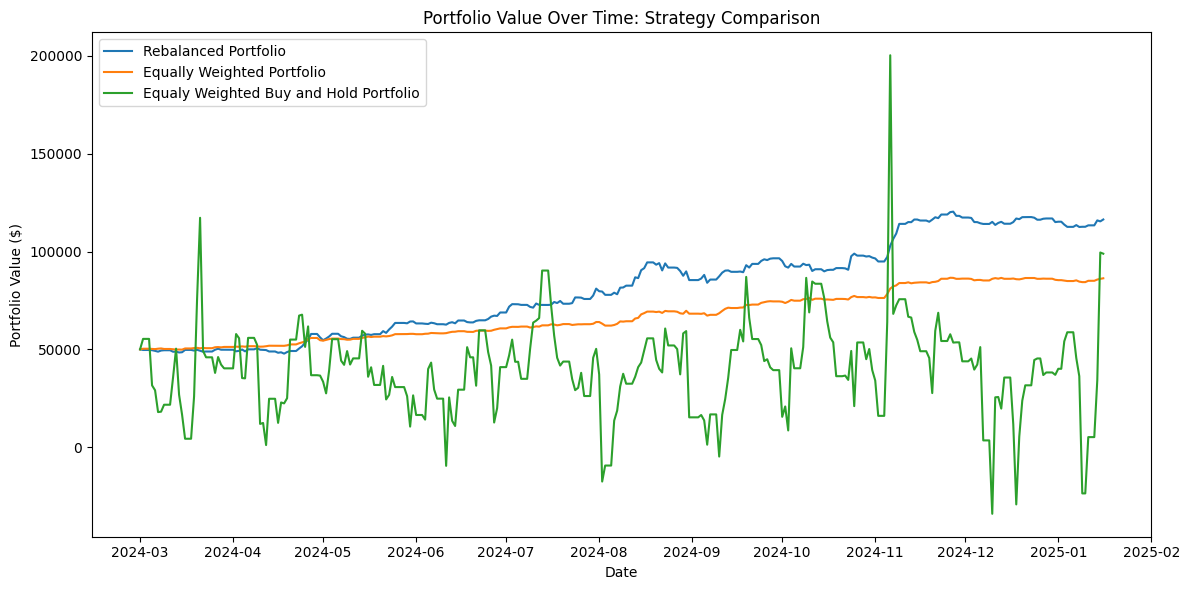

In [12]:
import matplotlib.pyplot as plt

def plot_all_portfolio(): 
    plt.figure(figsize=(12, 6))

    plt.plot(portfolio_daily_report.index, portfolio_daily_report['Total_Portfolio_Value'], label='Rebalanced Portfolio')
    plt.plot(equally_weighted_report.index, equally_weighted_report['Total_Portfolio_Value'], label='Equally Weighted Portfolio')
    plt.plot(equally_weighted_buy_and_hold_report.index, equally_weighted_buy_and_hold_report['Total_Portfolio_Value'], label='Equaly Weighted Buy and Hold Portfolio')

    plt.xlabel('Date')
    plt.ylabel('Portfolio Value ($)')
    plt.title('Portfolio Value Over Time: Strategy Comparison')
    plt.legend()
    plt.tight_layout()
    plt.show() 

plot_all_portfolio()

In [13]:
def combine_all_returns() : 
    combined_returns = pd.DataFrame()
    combined_returns.index = equally_weighted_buy_and_hold_report.index
    combined_returns['Value_Benchmark'] = equally_weighted_buy_and_hold_report['Total_Portfolio_Value']
    combined_returns['Value_EqualWeight'] = equally_weighted_report['Total_Portfolio_Value']
    combined_returns['Value_RebalanceStrategy'] = portfolio_daily_report['Total_Portfolio_Value'] 
    return combined_returns

combined_returns = combine_all_returns() 
combined_returns

,Value_Benchmark,Value_EqualWeight,Value_RebalanceStrategy
Date,,,
2024-03-01,50000.000000,50000.000000,50000.000000
2024-03-02,55353.757708,50321.460071,49686.808157
2024-03-03,55353.757708,50321.460071,49686.808157
2024-03-04,55353.757708,50321.460071,49686.808157
2024-03-05,31590.306138,50214.379823,49576.957671
...,...,...,...
2025-01-12,5138.016532,85053.336267,113401.363115
2025-01-13,5138.016532,85053.336267,113401.363115
2025-01-14,34225.060443,85691.223129,115937.344286


<Axes: xlabel='Date'>

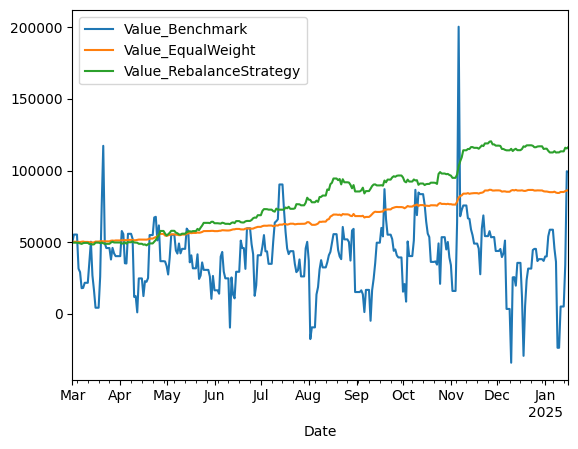

In [14]:
combined_returns.plot()

In [15]:
combined_returns.to_csv('Results/combined_values.csv')

In [16]:
def compute_cumulative_returns(df: pd.DataFrame) -> pd.DataFrame:

    start_vals = df.iloc[0]
    end_vals   = df.iloc[-1]

    # Map column names to strategy labels
    mapping = {
        "Value_Benchmark":        "Benchmark",
        "Value_EqualWeight":      "Equal weight",
        "Value_RebalanceStrategy":"Rebalance Strategy"
    }

    records = []
    for col, label in mapping.items():
        cum_ret = (end_vals[col] - start_vals[col]) / start_vals[col] * 100
        records.append({"Strategy": label, "Cumulative Return (%)": cum_ret})

    return pd.DataFrame.from_records(records)


cumulative_return_df = compute_cumulative_returns(combined_returns)
display(cumulative_return_df)

,Strategy,Cumulative Return (%)
0,Benchmark,97.818249
1,Equal weight,72.670812
2,Rebalance Strategy,132.801371
